In [1]:
from scipy.optimize  import curve_fit, fsolve
from scipy.special   import erf, betainc, gamma

from ROOT import TMVA,TH2F, TCanvas
import array, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# My Dependencies
from Data      import *
from Helper    import *

Welcome to JupyROOT 6.18/04


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/root_numpy/__init__.py:34: RuntimeWarning: ROOT 6.18/04 is currently active but you installed root_numpy against ROOT 6.05/02. Please consider reinstalling root_numpy for this ROOT version.
  RuntimeWarning)
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.0 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
import os, datetime

In [3]:
def dirStructure(figpath):
    date = datetime.datetime.now()
    fileName = str(date.year) + str(date.month) + str(date.day) + "/"
    
    try:
        os.mkdir(figpath+fileName)    
    except:
        print("Directory "+fileName+ " already exist")
        
    try :
        os.mkdir(figpath+fileName+'ShowerShapeMVA/')
    except:
        print("Directory "+fileName+'ShowerShapeMVA/ already exist')
    
    dirSubStructure(figpath + fileName + "Stacked/")
    dirSubStructure(figpath + fileName + "Unstacked/")
    
    dirSubStructure(figpath + fileName + "nJets/")
    for i in range(5):
        dirSubStructure(figpath + fileName + "nJets/Stacked_nJets"+str(i)+"/")
        dirSubStructure(figpath + fileName + "nJets/Unstacked_nJets"+str(i)+"/")
    
    return figpath+fileName  

def dirSubStructure(path):
    try:
        os.mkdir(path)
    except:
        print("Subdirectory for " + path + " already exists or failed.")
    
    try:
        os.mkdir(path+"log")
        os.mkdir(path+"log/Mult")
        os.mkdir(path+"linear")
        os.mkdir(path+"linear/Mult")
    except:
        print("Subdirectory for " + path + " already exists or failed.")

In [4]:
def BinFormat(Bins,ranges = None,Type='ranges', Print=False):
    bins = []
    if type(Bins) is int:
        try:
            step = int((ranges[1]-ranges[0])/Bins)
            if step*Bins+ranges[0] != ranges[1] and Print:
                print('Last bin will be omited')
        except:
            if Print:
                print('Please provide a range')
        
        if Type=='ranges':
            for i in range(Bins):
                bins.append([i*step+ranges[0],(i+1)*step+ranges[0]])
        elif Type == 'edges':
            for i in range(Bins+1):
                bins.append(i*step+ranges[0])
                
    else:
        if Type == 'ranges':
            if type(Bins[0]) is np.ndarray or type(Bins[0]) is list:
                bins = Bins
            else:
                for i in np.arange(len(Bins)-1):
                    bins.append([Bins[i],Bins[i+1]])
        elif Type == 'edges':
            if type(Bins[0]) is int or type(Bins[0]) is float or type(Bins[0]) is np.int64:
                bins = Bins
            else:
                for b in Bins:
                    bins.append(b[0])
                bins.append(Bins[-1][1])
            bins = array.array("f",bins)

    return bins

In [78]:
selection = 'mumug'
#selection = 'elelg'
#selection = 'ee'

#era = "2016"
era = "2017"

if era == "2016":
    run = ['B','C','D','E','F','G','H']
    #DataGen = 'rereco'
    DataGen = 'legacy'
    if DataGen == 'legacy':
        #SampleSet = 'MatchZGpaper'
        #SampleSet = 'Rerun'
        SampleSet = 'Correction'
    else:
        SampleSet = 'MatchZGpaper_newAna'
elif era == "2017":
    if selection == "mumug":
        run = ['B','C','D','E','F']
        DataGen = 'rereco'
        #SampleSet = 'V1'
        #SampleSet = 'V2_puWeight'
        #SampleSet = 'V2_puWeight_phID'
        #SampleSet = "V4_phID_isConv"
        SampleSet = "V4_phID_isConv_MINUIT"
    elif selection == "mumu":
        run = ['B','C','D','E','F']
        DataGen = 'rereco'
        #SampleSet = 'V1'
        #SampleSet = 'V2_puWeight'
        SampleSet = 'V2_puWeight_phID'
    elif selection == "ee":
        run = ['B','C','D','E','F']
        #run = ['D']
        DataGen = 'rereco'
        #SampleSet = 'EfficiencyCorrection/files_zee/CorrShower'
        SampleSet = 'EfficiencyCorrection/files_zee/V4_phID_isConv'
    LoadVars = [
            'runNumber','evtNumber',
            'nPV','nPU','Rho', 'met',
            'genWeight','eventWeight','puWeight','triggerWeight','photonIDWeight',"photonIsConvWeight",
            'leptonOnePt','leptonOneEta','leptonOnePhi','leptonOneIso','leptonOneCharge',
            'leptonTwoPt','leptonTwoEta','leptonTwoPhi','leptonTwoIso','leptonTwoCharge',
            'photonOnePt','photonOneEta','photonOnePhi',
            'photonOneR9','photonOneMVA','photonOneERes','photonOneSieie',
            'photonOneHoverE','photonOneIneu','photonOneIph','photonOneIch',
            'photonOneSieip','photonOneSipip','photonOneSrr','photonOneE2x2','photonOneE5x5',
            'photonOneScEtaWidth','photonOneScPhiWidth',
            'photonOneScRawE','photonOnePreShowerE','photonOneScBrem',
            'genPhotonPt',
            'vetoDY','genIsoPass',
            'dileptonPt','dileptonEta','dileptonPhi','dileptonM',
            'llgPt','llgEta','llgPhi','llgM',
            'dileptonDEta','dileptonDPhi','dileptonDR',
            'l1PhotonDEta','l1PhotonDPhi','l1PhotonDR',
            'l2PhotonDEta','l2PhotonDPhi','l2PhotonDR',
            'dileptonPhotonDEta','dileptonPhotonDPhi','dileptonPhotonDR',
            'nMuons','nElectrons','nPhotons','nJets',#'nTaus','nBJets',
            'passElectronVeto',
            ]        
        
    
pathMVA = "/home/jcordero/CMS/data_"+era+"/"+DataGen+"/SMP_ZG/Files/ShowerShapeMVA/"
path    = "/home/jcordero/CMS/data_"+era+"/"+DataGen+"/SMP_ZG/Files/"+selection+"/"+SampleSet+"/"
figpath = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/"+era+"/"+DataGen+"/"+selection+"/"

figpath = dirStructure(figpath)        
        
Help = Helper()

Directory 2020121/ already exist
Directory 2020121/ShowerShapeMVA/ already exist
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/2020121/Stacked/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/2020121/Stacked/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/2020121/Unstacked/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/2020121/Unstacked/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/2020121/nJets/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/2020121/nJets/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/2020121/nJets/Stacked_nJets0/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/2020121/nJets

In [6]:
'''
#DataGen = 'rereco'
DataGen = 'legacy'

selection = 'mumug'
#selection = 'elelg'

#SampleSet = 'HZG'
#SampleSet = 'WithMuonVeto'
#SampleSet = 'WithWJets'
if DataGen == 'legacy':
    #SampleSet = 'MatchZGpaper'
    #SampleSet = 'Rerun'
    SampleSet = 'Correction'
else:
    SampleSet = 'MatchZGpaper_newAna'
#SampleSet = 'ReRun'
#SampleSet = 'Z'

#pathData    = "/home/jcordero/CMS/data_2016/"+DataGen+"/SMP_ZG/Files/"+selection+"/"+SampleSet+"/"
path    = "/home/jcordero/CMS/data_2016/"+DataGen+"/SMP_ZG/Files/"+selection+"/"+SampleSet+"/"
figpath = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/"+DataGen+"/"+selection+"/"

Help    = Helper()
''';

In [7]:
# --------------------------------------
#  Data
# ---------------------------------------

LoadVars = []

if selection   == 'mumug':
    DoubleLepton = [Data(path+"DoubleMuon/","DoubleMuon_"+era,trigger = r,era = era,data=True, var = LoadVars) for r in run]
elif selection == 'elelg':
    DoubleLepton = [Data(path+"DoubleEG/","DoubleEG_"+era,trigger = r,era = era, data=True, var = LoadVars) for r in run]
elif selection == 'ee':
    #SingleLepton = [Data(path+"SingleElectron/","Electron_"+era,trigger = r,era = era, data=True, var = LoadVars) for r in run]
    SingleLepton = [Data(path+"SingleElectron/","Electron_"+era,trigger = r,era = '2017_RunD', data=True, var = LoadVars)]

#################################
Leptons = DoubleLepton[0]
for i in np.arange(len(DoubleLepton[1:])):
    Leptons =   Leptons + DoubleLepton[1]
    del DoubleLepton[1]    

----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/DoubleMuon/output_DoubleMuon_2017B_v.root
Opening    tree::   tree_DoubleMuon_2017B
-------------------------------------------------
----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/DoubleMuon/output_DoubleMuon_2017C_v.root
Opening    tree::   tree_DoubleMuon_2017C
-------------------------------------------------
----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/DoubleMuon/output_DoubleMuon_2017D_v.root
Opening    tree::   tree_DoubleMuon_2017D
-------------------------------------------------
----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/DoubleMuon/output_Doub

Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist


In [8]:
if selection == "mumug" or selection == "elelg":
    trigger    = "_v"
    DYJets     = Data(path +      "DYJets/",     "DYJets", trigger, era = era, var = LoadVars)
    if DataGen == "legacy" or era == '2017':
        ZG     = Data(path +   "ZGToLLG/",   "ZGToLLG", trigger, era = era, var = LoadVars)
        WJets  = Data(path +     "WJets/",     "WJets", trigger, era = era, var = LoadVars)
        TT     = Data(path + "TTTo2L2Nu/", "TTTo2L2Nu", trigger, era = era, var = LoadVars)
    elif DataGen == "rereco":
        ZG     = Data(path +    "ZG_ZToLL/",   "ZG_ZToLL", trigger, era = era, var = LoadVars)
        TT     = Data(path +          "TT/",         "TT", trigger, era = era, var = LoadVars)
        W1Jets = Data(path + "W1JetsToLNu/","W1JetsToLNu", trigger, era = era, var = LoadVars)
        W2Jets = Data(path + "W2JetsToLNu/","W2JetsToLNu", trigger, era = era, var = LoadVars)
        W3Jets = Data(path + "W2JetsToLNu/","W3JetsToLNu", trigger, era = era, var = LoadVars)
        W4Jets = Data(path + "W3JetsToLNu/","W4JetsToLNu", trigger, era = era, var = LoadVars)

    WWTo2L2Nu  = Data(path +   "WWTo2L2Nu/",  "WWTo2L2Nu", trigger, era = era, var = LoadVars)

    ZZTo2L2Nu  = Data(path +   "ZZTo2L2Nu/",  "ZZTo2L2Nu", trigger, era = era, var = LoadVars)
    ZZTo2L2Q   = Data(path +    "ZZTo2L2Q/",   "ZZTo2L2Q", trigger, era = era, var = LoadVars)
    ZZTo4L     = Data(path +      "ZZTo4L/",     "ZZTo4L", trigger, era = era, var = LoadVars)

    WZTo2L2Q   = Data(path +    "WZTo2L2Q/",   "WZTo2L2Q", trigger, era = era, var = LoadVars)
    WZTo3LNu   = Data(path +    "WZTo3LNu/",   "WZTo3LNu", trigger, era = era, var = LoadVars)
elif selection == "ee":
    trigger    = "_v"
    DYJets     = Data(path +      "DYJets/",     "DYJets", trigger, era = era, var = LoadVars)
    if DataGen == "legacy" or era == '2017':
        ZG     = Data(path +   "ZGToLLG/",   "ZGToLLG", trigger, era = era, var = LoadVars)
    elif DataGen == "rereco":
        ZG     = Data(path +    "ZG_ZToLL/",   "ZG_ZToLL", trigger, era = era, var = LoadVars)


-------------------- MC -----------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/DYJets/output_DYJets_v_0.root
Opening    tree::   tree_dyjets
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/ZGToLLG/output_ZGToLLG_v_0.root
Opening    tree::   tree_zgtollg
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/WJets/output_WJets_v_0.root
Opening    tree::   tree_wjets
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/TTTo2L2Nu/output_TTTo2L2Nu_v_0.root
Opening    tree::   tree_ttto2l2nu
-------------------------------

In [9]:
if selection != "ee":  
    print(' +++ Merging MC Samples')
    if DataGen == "rereco" and era == "2016":
        WJets = W1Jets + W2Jets + W3Jets + W3Jets

    WW = WWTo2L2Nu
    ZZ = ZZTo2L2Nu + ZZTo2L2Q + ZZTo4L
    WZ = WZTo2L2Q + WZTo3LNu

    VV = WWTo2L2Nu + ZZTo2L2Nu + ZZTo2L2Q + ZZTo4L + WZTo2L2Q + WZTo3LNu
    
    #del ZZTo2L2Nu, ZZTo2L2Q, ZZTo4L, WWTo2L2Nu, WZTo2L2Q, WZTo3LNu
    print('--Done')

 +++ Merging MC Samples
-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------
-------------------- MC -----------------------
Open

Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist
Error in <TFile::TFile>: file output__0.root does not exist


In [57]:
import copy
if selection != "ee":
    #dataSelect = 'ALL'
    #dataSelect = 'DY Only
    #dataSelect = 'noTT'
    #dataSelect = 'DYVeto'
    #dataSelect = 'DY ZG'
    #dataSelect = 'DY ZG Comp'    
    #dataSelect = 'DY Compare'
    #dataSelect = 'no ZG'
    dataSelect = 'no DYJets'


    if   dataSelect == 'ALL':
        data        = [  WJets,         VV,     TT,   DYJets,        ZG,      Leptons]
        listSamples = [ 'WJets',      'V-V',   'TT', 'DYJets',      'ZG', 'Data']
        legend      = [ ' WJets',   '   V-V', '    TT', 'DYJets',  '    ZG', 'Data']
        colors      = [     'cornflowerblue',    'lightskyblue',    'lightcoral', 'plum',     'pink',          'k']
        dataFlag    = [   False,     False,  False,    False,     False,         True]
        combFlag    = [   False,     False,  False,    False,     False,         True]
    elif dataSelect == "noTT":
        data        = [  WJets,         VV,   DYJets,        ZG,      Leptons]
        listSamples = [ 'WJets',      'VV', 'DYJets',      'ZG', 'DoubleMuon']
        legend      = [ 'WJets',      'VV', 'DYJets',      'ZG', 'DoubleMuon']
        colors      = [     'b',    'cyan', 'purple', 'magenta',          'k']
        dataFlag    = [   False,     False,    False,     False,         True]
        combFlag    = [   False,     False,    False,     False,         True]
    elif dataSelect == 'VV Separate':
        data        = [  DYJets,   WJets,       TT,       WW,      ZZ,       WZ,       ZG,    Leptons]
        listSamples = ['DYJets', 'WJets',      'TT',    'WW',    'ZZ',     'WZ',      'ZG', 'DoubleMuon']
        legend      = ['DYJets', 'WJets',      'TT',    'WW',    'ZZ',     'WZ',      'ZG', 'DoubleMuon']
        colors      = [  'cyan',     'r',  'purple',    'grey',  'teal', 'orange', 'magenta',          'k']
        dataFlag    = [   False,   False,     False,   False,   False,    False,     False,         True]
        combFlag    = [   False,   False,     False,   False,   False,    False,     False,         True]
    elif dataSelect == 'DY Only':    
        data        = [  DYJets, Leptons]
        listSamples = ['DYJets', 'DoubleMuon']
        legend      = ['DYJets', 'DoubleMuon']
        colors      = [  'cyan', 'k']
        dataFlag    = [   False, True]
        combFlag    = [   False, True]
    elif dataSelect == 'DY Compare':    
        DYJets_SideBand = copy.deepcopy(DYJets)

        data        = [  DYJets,DYJets_SideBand, Leptons]
        listSamples = ['DYJets','DYJets', 'DoubleMuon']
        legend      = ['DYJets', 'DYJets','DoubleMuon']
        colors      = [  'cyan', 'magenta','k']
        dataFlag    = [   False, False, True]    
        combFlag    = [   False, False, True]   

        data[0].name = 'DYJets_Sig'
        data[1].name = 'DYJets_SideBand'
    elif dataSelect == 'DYVeto':
        data        = [  DYJets,   WJets,       TT,       WW,      ZZ,       WZ,       ZG_veto,    Leptons]
        listSamples = ['DYJets', 'WJets',      'TT',    'WW',    'ZZ',     'WZ',      'ZG', 'DoubleMuon']
        legend      = ['DYJets', 'WJets',      'TT',    'WW',    'ZZ',     'WZ',      'ZG', 'DoubleMuon']
        colors      = [  'cyan',     'r',  'purple',    'grey',  'teal', 'orange', 'magenta',          'k']
        dataFlag    = [   False,   False,     False,   False,   False,    False,     False,         True]
        combFlag    = [   False,   False,     False,   False,   False,    False,     False,         True]
    elif dataSelect == 'DY ZG':
        data        = [  DYJets,      ZG,    Leptons]
        listSamples = ['DYJets',      'ZG', 'DoubleMuon']
        legend      = ['DYJets',      'ZG', 'DoubleMuon']
        colors      = [  'cyan',      'magenta',          'k']
        dataFlag    = [   False,     False,         True]
        combFlag    = [   False,     False,         True]
    elif dataSelect == 'DY ZG Comp':    
        data        = [  ZG_veto,      ZG,    Leptons]
        listSamples = ['DYJets',      'ZG', 'DoubleMuon']
        legend      = ['DYJets',      'ZG', 'DoubleMuon']
        colors      = [  'cyan',      'magenta',          'k']
        dataFlag    = [   False,     False,         True]
        combFlag    = [   False,     False,         True]
    elif dataSelect == 'no ZG':
        data        = [  WJets,         VV,     TT,   DYJets,     Leptons]
        listSamples = [ 'WJets',      'V-V',   'TT', 'DYJets','Data']
        legend      = [ 'WJets',      'V-V',   'TT', 'DYJets','Data']
        colors      = [     'cornflowerblue',    'lightskyblue',    'lightcoral', 'plum', 'k']
        dataFlag    = [   False,     False,  False,    False,        True]
        combFlag    = [   False,     False,  False,    False,        True]
    elif dataSelect == "no DYJets":
        data        = [           WJets,               VV,        TT,        ZG,      Leptons]
        listSamples = [         'WJets',            'V-V',      'TT',       'ZG', 'Data']
        legend      = [        ' WJets',         '   V-V',  '    TT',  '    ZG', 'Data']
        colors      = ['cornflowerblue',   'lightskyblue', 'lightcoral',     'pink',          'k']
        dataFlag    = [   False,     False,  False,    False,        True]
        combFlag    = [   False,     False,  False,    False,        True]

    ind = []
    for i in range(len(data)):
        if len(data[i].df.columns) <= 1:
            continue
        else: 
            ind.append(i)

    data        = [data[i]        for i in ind]
    listSamples = [listSamples[i] for i in ind]
    legend      = [legend[i]      for i in ind]
    colors      = [colors[i]      for i in ind]
    dataFlag    = [dataFlag[i]    for i in ind]
    combFlag    = [combFlag[i]    for i in ind]

    for i in range(len(data)):
        print(i,data[i].name,colors[i])    
else:
    data        = [DYJets,   Leptons]
    listSamples = ['DYJets',  'Data']
    legend      = ['DYJets',  'Data']
    colors      = [  'plum',     'k']
    dataFlag    = [   False,    True]
    combFlag    = [   False,    True]

0 WJets cornflowerblue
1 WWTo2L2Nu lightskyblue
2 TTTo2L2Nu lightcoral
3 ZGToLLG pink
4 DoubleMuon_2017 k


# Cuts

In [65]:
def STD_Cuts(
            data,
            phType = 'ISR',
            Charge ='oposite',
            Print = False,
            MVA   = False,
            ):
    
    [d.ResetCuts() for d in data]
    #---------------------------- CUTS ------------------------------------ CUTS -----------------------
    # The proper cut
    DYJets .AddCuts(np.array(DYJets.df.vetoDY)==False)
    #ZG_veto.AddCuts(np.array(ZG_veto.df.vetoDY)==True )


    for d in data:
        #d.AddCuts(np.array(d.df.photonOnePt)>10)
        if Print:
            print('-----------------',d.name,'--------------')
            print('----Total----')
            print(sum(d.cuts))

        #if(DataGen == "legacy"):
        #    d.AddCuts(np.array(d.df.genIsoPass == True))
        #    if Print:
        #        print('----genIsoPass----')
        #        print(sum(d.cuts))
        
        d.AddCuts(np.array(d.df.l1PhotonDR) > 0.7)
        d.AddCuts(np.array(d.df.l2PhotonDR) > 0.7)
        if Print:
            print('----DR cuts ----')
            print(sum(d.cuts))

        
        if phType == 'ISR':
            # 2 Body to get ISR
            d.AddCuts(np.array(d.df.llgM)+np.array(d.df.dileptonM) > 185)
        elif phType == 'FSR' :
            # 3 Body to get FSR
            d.AddCuts(np.array(d.df.llgM)+np.array(d.df.dileptonM) < 185)
        if Print:
            print('----Mass cuts ----')  
            print(sum(d.cuts))

        if MVA:
            d.AddCuts(np.array(d.df.photonOneMVA > 0.2))
        if Print:
            print('----MVA cuts ----')  
            print(sum(d.cuts))
        #d.AddCuts(np.array(d.df.nJets)==0)
        #d.AddCuts(np.array(d.df.nJets)==1)
        #d.AddCuts(np.array(d.df.nJets)>1)
        #d.AddCuts(np.array(d.df.photonOneIph) > 0.6)

        # MVA CUT
        #d.AddCuts(np.array(d.df.photonOneMVA) > 0.5)
        #d.AddCuts(np.array(d.df.photonOneMVA)-5*np.array(d.df.photonOneHoverE) -0.6 > 0)


        
        if Charge == 'oposite':
            d.AddCuts(np.array(d.df.leptonOneCharge) != np.array(d.df.leptonTwoCharge))
        elif Charge == 'same':
            d.AddCuts(np.array(d.df.leptonOneCharge) == np.array(d.df.leptonTwoCharge))
        if Print:
            print('----Charge cuts ----')
            print(sum(d.cuts))
            
def PhaseSpace(
                data,
                phType = 'ISR',
                Charge = 'oposite',
                Region = '',
                Print  = False,
                MVA    = False,
              ):   
    
    STD_Cuts( data, phType = phType, Charge = Charge, Print = Print , MVA = MVA)
    
    for d in data:            
        if Print:
            print('-------'+d.name+'-------')
            print('----- Standard Region')
            print(sum(d.cuts))
    
        if Region == 'Sig':            
            if Print:
                print('-------'+d.name+'-------')
                print('----- Total')
                print(sum(d.cuts))
            SigRegion = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 2.0,
                                      np.array(d.df.photonOneIch_EE) < 1.5 
                                     )
            d.AddCuts(SigRegion)
            #d.AddCuts()
            
            if Print:
                print('----- Signal Region')
                print(sum(d.cuts))
        elif Region == "Inv Sig":
            if Print:
                print('-------'+d.name+'-------')
                print('----- Total')
                print(sum(d.cuts))
            SigRegion = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 2.0,
                                      np.array(d.df.photonOneIch_EE) >= 1.5 
                                     )
            d.AddCuts(SigRegion)
            #d.AddCuts()
            
            if Print:
                print('----- Signal Region')
                print(sum(d.cuts))
        elif Region == 'Sideband':
            if Print:
                print('-------'+d.name+'-------')
                print('----- Total')
                print(sum(d.cuts))
            SideBandRegion = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 2.0,
                                      np.array(d.df.photonOneIch_EE) >= 1.5 
                                     )
            d.AddCuts(SideBandRegion)
            #d.AddCuts()
            
            if Print:
                print('----- Signal Region')
                print(sum(d.cuts))            
        elif Region == 'Compare':
            print(d.name)
            if d.name == 'DYJets_Sig':
                SigRegion = np.logical_or(
                                          np.array(d.df.photonOneIch_EB) < 2.0,
                                          np.array(d.df.photonOneIch_EE) < 1.5 
                                         )
                d.AddCuts(SigRegion)
                
            elif d.name == 'DYJets_SideBand':
                SideBandRegion = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 2.0,
                                      np.array(d.df.photonOneIch_EE) >= 1.5 
                                     )
                d.AddCuts(SideBandRegion)
                
        ##########################################
        ## Background Estimation ABCD Method
        elif Region == 'A' :
            A1_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 2,
                                      np.array(d.df.photonOneIch_EE) < 1.5
                                     )
            A2_Region = np.logical_or(np.array(d.df.photonOneSieie_EB) < 0.01015,
                                      np.array(d.df.photonOneSieie_EE) < 0.0272
                                      )
            
            d.AddCuts( np.logical_and(A1_Region, A2_Region) )
        elif Region == 'B' :
            B1_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 2,
                                      np.array(d.df.photonOneIch_EE) < 1.5
                                     )
            B2_Region = np.logical_or(np.array(d.df.photonOneSieie_EB) >= 0.011,
                                      np.array(d.df.photonOneSieie_EE) >= 0.03
                                      )
            
            d.AddCuts( np.logical_and(B1_Region, B2_Region) )
        elif Region == 'C' :
            C11_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 3.5,
                                      np.array(d.df.photonOneIch_EE) >= 3.5
                                     )
            C12_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 12,
                                      np.array(d.df.photonOneIch_EE) < 12
                                     )
            C1_Region = np.logical_and( C11_Region, C12_Region)
            
            C2_Region = np.logical_or(np.array(d.df.photonOneSieie_EB) < 0.01015,
                                      np.array(d.df.photonOneSieie_EE) < 0.0272
                                      )
            
            d.AddCuts( np.logical_and(C1_Region, C2_Region) )
        elif Region == 'D' :
            D11_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 3.5,
                                      np.array(d.df.photonOneIch_EE) >= 3.5
                                     )
            D12_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 12,
                                      np.array(d.df.photonOneIch_EE) < 12
                                     )
            D1_Region = np.logical_and( D11_Region, D12_Region)
            
            D2_Region = np.logical_or(np.array(d.df.photonOneSieie_EB) >= 0.011,
                                      np.array(d.df.photonOneSieie_EE) >= 0.03
                                      )
            
            d.AddCuts( np.logical_and(D1_Region, D2_Region) )
        elif Region == 'AB' :
            AB_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 2,
                                      np.array(d.df.photonOneIch_EE) < 1.5
                                     )
            
            d.AddCuts( AB_Region )
        elif Region == 'CD' :
            CD1_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 3.5,
                                      np.array(d.df.photonOneIch_EE) >= 3.5
                                     )
            CD2_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 12,
                                      np.array(d.df.photonOneIch_EE) < 12
                                     )
            CD_Region = np.logical_and( CD1_Region, CD2_Region)
            
            d.AddCuts( CD_Region )
               

# ReWeight

In [59]:
def GetMCPU():
    ########### MC Scenario ##################
    PU = np.array([
                    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                    11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
                    31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
                    41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 
                    51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 
                    61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
                    71, 72, 73, 74]
                    )
    PUmc = np.array([
                    1.78653e-05 ,2.56602e-05 ,5.27857e-05 ,8.88954e-05 ,
                    0.000109362 ,0.000140973 ,0.000240998  ,0.00071209  ,
                    0.00130121  ,0.00245255  ,0.00502589   ,0.00919534  ,
                    0.0146697   ,0.0204126   ,0.0267586    ,0.0337697   ,
                    0.0401478   ,0.0450159   ,0.0490577    ,0.0524855   ,
                    0.0548159   ,0.0559937   ,0.0554468    ,0.0537687   ,
                    0.0512055   ,0.0476713   ,0.0435312    ,0.0393107   ,
                    0.0349812   ,0.0307413   ,0.0272425    ,0.0237115   ,
                    0.0208329   ,0.0182459   ,0.0160712    ,0.0142498   ,
                    0.012804    ,0.011571    ,0.010547     ,0.00959489  ,
                    0.00891718  ,0.00829292  ,0.0076195    ,0.0069806   ,
                    0.0062025   ,0.00546581  ,0.00484127   ,0.00407168  ,
                    0.00337681  ,0.00269893  ,0.00212473   ,0.00160208  ,
                    0.00117884  ,0.000859662 ,0.000569085  ,0.000365431 ,
                    0.000243565 ,0.00015688  ,9.88128e-05  ,6.53783e-05 ,
                    3.73924e-05 ,2.61382e-05 ,2.0307e-05   ,1.73032e-05 ,
                    1.435e-05   ,1.36486e-05 ,1.35555e-05  ,1.37491e-05 ,
                    1.34255e-05 ,1.33987e-05 ,1.34061e-05  ,1.34211e-05 ,
                    1.34177e-05 ,1.32959e-05 ,1.33287e-05]
                    )
    
    return PU,PUmc

def GetDataPU(xsec='69p2'):
    pileupFile = 'pileup_sf_2016_'+xsec+'mb.root'
    file = TFile('/home/jcordero/CMS/data_2016/'+DataGen+'/SMP_ZG/Files/'+pileupFile)
    puTree = file.Get('pileup')
    PUdata = []
    for pu in puTree:
        PUdata.append(pu)
    return PUdata

def GetPUweight(xsec='69p2'):
    
    ### Get Distributions ##
    PU,PUmc= GetMCPU()
    PUdata = GetDataPU(xsec)
    
    ### Normalize ###
    PUmc   = np.array(PUmc)/sum(PUmc)        
    PUdata = np.array(PUdata)/sum(PUdata)
    
    return PU,PUdata/PUmc,PUdata,PUmc,

def SF_ratio(
             xsec1='65',
             xsec2='69p2',
            ):
    pu,r1,r1d,r1m = GetPUweight(xsec = xsec1)
    pu,r2,r2d,r2m = GetPUweight(xsec = xsec2)
    rScale = r1/r2
    rScale[np.isnan(rScale)] = np.ones(sum(np.isnan(rScale)))

    puWeight = []
    for d in data[:-1]:
        puW = np.ones(len(d.df.nPU))
        print('--------------',d.name)
        print(len(d.df.nPU))
        for i in range(len(pu)-2):
            mask = np.logical_and(np.array(d.df.nPU) > pu[i], np.array(d.df.nPU) <= pu[i+1])        
            puW[mask] = np.ones(np.sum(mask))*rScale[i]
        puWeight.append(puW)
    return puWeight

In [60]:
################################
#stacked = False
stacked = True

LOG = 'both'
log = False
#log = True

weightCorrection = True 
#weightCorrection = False
if era == "2016":
    xsec1, xsec2 = '65','69p2'    
elif era == "2017":
    #xsec1, xsec2 = '70','69p2'
    #xsec1, xsec2 = '72p4','69p2'
    xsec1, xsec2 = '65','69p2'

#phType = 'ISR'
#phType = 'FSR'
phType = ''

#Region = 'Sig'
Region = 'Inv Sig'
#Region = 'Sideband'
#Region = 'Compare'
#Region = ''

Charge = 'oposite'
#Charge = 'same'

#customRange = True
customRange = False

MVA = False
#MVA = True

Print = False
#Print = True
###############################
if stacked:
    Fol  = 'Stacked'
    stackLab  = ''
    histtype  = 'stepfilled'
    density   = False
    linewidth = 1
else:
    Fol  = 'Unstacked'
    stackLab  = ''
    histtype  = 'step'
    density   = True
    #density = False
    linewidth = 1.7
###############################    
if log:
    stackFol = Fol+'/log'
else:
    stackFol = Fol+'/linear'
###############################

######## CUTS ##############
PhaseSpace(
            data,
            phType = phType,
            Charge = Charge,
            Region = Region,
            Print  = Print,
            MVA    = MVA,
          )

for d in data[:-1]:
    d.AddCuts(np.array(d.df.nPU) > 0) 
###############################

/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in less


In [61]:
if weightCorrection:
    reWeight = []
    puWeight = SF_ratio(xsec1=xsec1,xsec2=xsec2)
    for i in range(len(data[:-1])):
        reWeight.append(data[i].weight*puWeight[i])

/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


-------------- WJets
1
-------------- WWTo2L2Nu
472293
-------------- TTTo2L2Nu
2364
-------------- ZGToLLG
396138


In [15]:
#path = "/eos/uscms/store/user/corderom/Corrections2016Rereco/"
phVals = ["EE","EB"]
#phVals = ["EE"]
#phVals = ["EB"]

path = ""
file = {}
reader = {}
for ph in phVals:
    if era == "2016":
        preName = "spring16_80x_"+ph
    elif era == "2017":
        preName = "fall17_94X_"+ph
    elif era == "2018":
        preName = "autum18_"+ph
    file[ph] = pathMVA+preName+"_TMVAnalysis_BDT.weights.xml"
    reader[ph] = TMVA.Reader()


In [16]:
varName     = {"EE":{
            "recoPhi"                :["photonOnePhi"],
            "r9"                     :["photonOneR9"],
            "sieieFull5x5"           :["photonOneSieie"],
            "sieipFull5x5"           :["photonOneSieip"],
            "e2x2Full5x5/e5x5Full5x5":["photonOneE2x2","photonOneE5x5"],
            "recoSCEta"              :["photonOneEta"],
            "rawE"                   :["photonOneScRawE"],
            "scEtaWidth"             :["photonOneScEtaWidth"],
            "scPhiWidth"             :["photonOneScPhiWidth"],
            "esEn/rawE"              :["photonOnePreShowerE","photonOneScRawE"],
            "esRR"                   :["photonOneSrr"],
            "rho"                    :["Rho"],
            },
          "EB":{
            "recoPhi"                :["photonOnePhi"],
            "r9"                     :["photonOneR9"],
            "sieieFull5x5"           :["photonOneSieie"],
            "sieipFull5x5"           :["photonOneSieip"],
            "e2x2Full5x5/e5x5Full5x5":["photonOneE2x2","photonOneE5x5"],
            "recoSCEta"              :["photonOneEta"],
            "rawE"                   :["photonOneScRawE"],
            "scEtaWidth"             :["photonOneScEtaWidth"],
            "scPhiWidth"             :["photonOneScPhiWidth"],
            "rho"                    :["Rho"],
            }
        }
varNaming   = {"EE":[
                "recoPhi"                ,
                "r9"                     ,
                "sieieFull5x5"           ,
                "sieipFull5x5"           ,
                "e2x2Full5x5/e5x5Full5x5",
                "recoSCEta"              ,
                "rawE"                   ,
                "scEtaWidth"             ,
                "scPhiWidth"             ,
                "esEn/rawE"              ,
                "esRR"                   ,
                "rho"                    ,
                ],
            "EB":[
                "recoPhi"                ,
                "r9"                     ,
                "sieieFull5x5"           ,
                "sieipFull5x5"           ,
                "e2x2Full5x5/e5x5Full5x5",
                "recoSCEta"              ,
                "rawE"                   ,
                "scEtaWidth"             ,
                "scPhiWidth"             ,
                "rho"                    ,
                ]
           }
myVarNaming = {"EE":[
                    ["photonOnePhi"],
                    ["photonOneR9"],
                    ["photonOneSieie"],
                    ["photonOneSieip"],
                    ["photonOneE2x2","photonOneE5x5"],
                    ["photonOneEta"],
                    ["photonOneScRawE"],
                    ["photonOneScEtaWidth"],
                    ["photonOneScPhiWidth"],
                    ["photonOnePreShowerE","photonOneScRawE"],
                    ["photonOneSrr"],
                    ["Rho"],
                    ],
            "EB": [["photonOnePhi"],
                    ["photonOneR9"],
                    ["photonOneSieie"],
                    ["photonOneSieip"],
                    ["photonOneE2x2","photonOneE5x5"],
                    ["photonOneEta"],
                    ["photonOneScRawE"],
                    ["photonOneScEtaWidth"],
                    ["photonOneScPhiWidth"],
                    ["photonOnePreShowerE","photonOneScRawE"],
                    ["photonOneSrr"],
                    ["Rho"],
                    ]
             }

In [17]:
for d in data:
    print(d.name,len(d.df.runNumber))

WJets 1
WWTo2L2Nu 472293
TTTo2L2Nu 2364
DYJets 369514
ZGToLLG 396138
DoubleMuon_2017 440220


In [18]:

inMVA = {}
for ph in phVals:
    inMVA[ph] = {}
    for d in data:
        inMVA[ph][d.name] = {}

        print('---------------',d.name,'--------------')
        for i in np.arange(len(varNaming[ph])):
            VARS = [d.GetWithCuts(v) for v in myVarNaming[ph][i]]
            if d.name == 'WWTo2L2Nu':
                if varNaming[ph][i] == "recoPhi":
                    print(VARS[0])
                    #print(VARS[1])

            if len(VARS) >1:
                inMVA[ph][d.name][varNaming[ph][i]] = np.array(VARS[0])/np.array(VARS[1])
            else:
                inMVA[ph][d.name][varNaming[ph][i]] = VARS[0]
            #print(varNaming[i],inMVA[d.name][varNaming[i]][0])


--------------- WJets --------------
--------------- WWTo2L2Nu --------------
[-2.3406405   1.6647083  -1.921082   ... -0.37367734  0.77331835
 -0.07232407]
--------------- TTTo2L2Nu --------------
--------------- DYJets --------------
--------------- ZGToLLG --------------
--------------- DoubleMuon_2017 --------------
--------------- WJets --------------
--------------- WWTo2L2Nu --------------
[-2.3406405   1.6647083  -1.921082   ... -0.37367734  0.77331835
 -0.07232407]
--------------- TTTo2L2Nu --------------
--------------- DYJets --------------
--------------- ZGToLLG --------------
--------------- DoubleMuon_2017 --------------


In [19]:
var = {}
for ph in phVals:
    var[ph] = {}
    for i in np.arange(len(varNaming[ph])):
            var[ph][varNaming[ph][i]] = array.array('f',[0])
            reader[ph].AddVariable(varNaming[ph][i], var[ph][varNaming[ph][i]])
    reader[ph].BookMVA("BDT",file[ph])        

                         : Booking "BDT" of type "BDT" from /home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ShowerShapeMVA/fall17_94X_EE_TMVAnalysis_BDT.weights.xml.
                         : Reading weight file: /home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ShowerShapeMVA/fall17_94X_EE_TMVAnalysis_BDT.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT" of type: "BDT"
                         : Booking "BDT" of type "BDT" from /home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ShowerShapeMVA/fall17_94X_EB_TMVAnalysis_BDT.weights.xml.
                         : Reading weight file: /home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ShowerShapeMVA/fall17_94X_EB_TMVAnalysis_BDT.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
        

In [20]:
'''
for ph in phVals:
    print('============='+ph+"============")
    for d in data:
        print('--------',d.name,'-------',len(inMVA[ph][d.name]["recoPhi"]))
        for i in range(len(inMVA[ph][d.name]["recoPhi"])):
            for v in inMVA[ph][d.name]:
                var[ph][v][0] = inMVA[ph][d.name][v][i]
                if i == 0:
                    print(v, var[ph][v])

'''

'\nfor ph in phVals:\n    print(\'=============\'+ph+"============")\n    for d in data:\n        print(\'--------\',d.name,\'-------\',len(inMVA[ph][d.name]["recoPhi"]))\n        for i in range(len(inMVA[ph][d.name]["recoPhi"])):\n            for v in inMVA[ph][d.name]:\n                var[ph][v][0] = inMVA[ph][d.name][v][i]\n                if i == 0:\n                    print(v, var[ph][v])\n\n'

In [21]:
BDT = {}
for ph in phVals:
    print('============='+ph+"============")
    BDT[ph] = {}
    for d in data:
        print('--------',d.name,'-------',len(inMVA[ph][d.name]["recoPhi"]))
        BDT[ph][d.name] = []
        for i in range(len(inMVA[ph][d.name]["recoPhi"])):
            for v in inMVA[ph][d.name]:
                var[ph][v][0] = inMVA[ph][d.name][v][i]
                
            BDT[ph][d.name].append(reader[ph].EvaluateMVA("BDT"))



=============EE============
-------- WJets ------- 0
-------- WWTo2L2Nu ------- 166236
-------- TTTo2L2Nu ------- 530
-------- DYJets ------- 70493
-------- ZGToLLG ------- 261610
-------- DoubleMuon_2017 ------- 178988
=============EB============
-------- WJets ------- 0
-------- WWTo2L2Nu ------- 166236
-------- TTTo2L2Nu ------- 530
-------- DYJets ------- 70493
-------- ZGToLLG ------- 261610
-------- DoubleMuon_2017 ------- 178988


# Getting the Sideband region

In [ ]:
D = DYJets

histPlot = False
#histPlot = True

SAVE = {}
boundsU = 12

phType = "EB"
#phType = "EE"

#boundsL = [2,1.5]
boundRange = np.arange(2,boundsU-1,step=0.5)


#boundRange = [7.5,7] ## BEST range for EB
#boundRange = [3.5,3] ## BEST range for EE


#log = False
log = True
DENSITY = True
for bs in boundRange:
    print('---------------'+str(bs)+'-----------------')
    SUBS = []
    boundsL = [bs,bs-0.5]
    
    for i in np.arange(len(mllBins)):
        #print('---------------'+str(mllBins[i])+'-----------------')

        var = 'Sieie'
        part = 'photonOne_'+phType

        K = part+'_'+var
        Ks = K.split('_')

        if len(Ks)>2:
            part,var,ph = Ks[0],Ks[2],'_'+Ks[1]
        else:
            part,var,ph= Ks[0],Ks[1],''

        #################################################################    
        PhaseSpace(
                    [BDT[phType]['DYJets']],
                    #data,
                    phType = phType,
                    Charge = Charge,
                    Region = 'Inv Sig',
                    Print  = Print,
                    MVA    = MVA,
                    vetoDY = vetoDY,
                  )


        for d in [D]:
            mllRange = np.logical_and(
                                    np.array(d.df.dileptonM) > mllBins[i][0], 
                                    np.array(d.df.dileptonM) < mllBins[i][1]
                                    )
            d.AddCuts( mllRange )


        for d in [D]:
            AB_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < boundsL[0],
                                      np.array(d.df.photonOneIch_EE) < boundsL[1]
                                     )

            d.AddCuts( AB_Region ) 

        ranges,bins = GET_RangeBins(Ks, Blind=False,Plotting=Plotting)
        wei, VAR    = GET_WeiVAR(data, Ks, weightCorrection=weightCorrection )

        if histPlot:
            fig = plt.figure()
            h1 = plt.hist(
                        D.GetWithCuts(part+var+ph),
                        weights   = D.GetWithCuts('weights'),
                        bins      = bins,
                        histtype  = 'step',
                        linewidth = 1.7,
                        color     = 'b',
                        label     = 'AB',
                        density   = True,
                        )
            plt.xlabel(var)
            plt.title(part+ph)
            plt.grid(linestyle = '--')
            plt.legend()
        else:
            h1 = np.histogram(
                            D.GetWithCuts(part+var+ph),
                            weights   = D.GetWithCuts('weights'),
                            bins      = bins,
                            )

        ###################################################################
        PhaseSpace(
                    [D],
                    #data,
                    phType = phType,
                    Charge = Charge,
                    Region = 'Sig',
                    Print  = Print,
                    MVA    = MVA,
                    vetoDY = vetoDY,
                  )


        for d in [D]:
            mllRange = np.logical_and(
                                    np.array(d.df.dileptonM) > mllBins[i][0], 
                                    np.array(d.df.dileptonM) < mllBins[i][1]
                                    )
            d.AddCuts( mllRange )
        for d in [D]:
            CD1_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= boundsL[0],
                                      np.array(d.df.photonOneIch_EE) >= boundsL[1]
                                     )

            CD2_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < boundsU,
                                      np.array(d.df.photonOneIch_EE) < boundsU
                                     )
            d.AddCuts( np.logical_and(CD1_Region,CD2_Region) )    

        ranges,bins = GET_RangeBins(Ks, Blind=False,Plotting=Plotting)
        wei, VAR    = GET_WeiVAR(data, Ks, weightCorrection=weightCorrection )

        if histPlot:
            h2 = plt.hist(
                        D.GetWithCuts(part+var+ph),
                        weights   = D.GetWithCuts('weights'),
                        bins      = bins,
                        histtype  = 'step',
                        linewidth = 1.7,
                        color     = 'orange',
                        label     = 'CD',
                        density   = True,
                        )
            plt.xlabel(var)
            plt.title(part+ph)
            plt.grid(linestyle = '--')
            plt.legend()
            
            
            plt.show()
            fig.savefig(figpath+part+var+ph+'_'+str(i)+'.png')
        else:
            h2 = np.histogram(
                            D.GetWithCuts(part+var+ph),
                            weights   = D.GetWithCuts('weights'),
                            bins      = bins,
                            )

        SUBS.append(np.abs(h1[0]-h2[0]))
        

    SAVE[str(boundsL)+' U'+str(boundsU)] = np.sum([np.sum(sb) for sb in SUBS])

# Plotting the MVA distributions

In [55]:
ph = 'EB'

etaBins = [0,1.456666]
#etaBins = [1.4566,2.5]
#etaBins = [-2.5,-1.4566]
#etaBins = [-1.4566,0]

#ptBins = [20, 25, 30, 35, 45, 55, 65, 75, 85, 95, 120, 1000]
#ptBins = [20, 25, 30, 35, 45, 55]

#ptBins = [20,22,25,27,29,32,35,40,45,50,55,60,65,70,75,80,85,90,95,105,120,200,100]
ptBins = [20,22,25,27,29,32,35,40,45,50,55,60]
#ptBins = [65,70,75,80,85,90,95,105,120,200,1000]
variable = 'photonOnePt'
Ind = {}

for d in data:
    Ind[d.name] = []
    for i in np.arange(len(ptBins[:-1])):
        #print('[',ptBins[i],ptBins[i+1],']')
        ptInd = np.logical_and(
                            np.array(d.GetWithCuts(variable)) >= ptBins[i], 
                            np.array(d.GetWithCuts(variable)) <  ptBins[i+1]
                          )
        
        etaInd = np.logical_and(
                                np.array(d.GetWithCuts('photonOneEta')) >= etaBins[0], 
                                np.array(d.GetWithCuts('photonOneEta')) <  etaBins[1]
                               )
        
        #etaInd = np.logical_and(
        #                        np.array(d.GetWithCuts('photonOneEta')) >= etaBins[i], 
        #                        np.array(d.GetWithCuts('photonOneEta')) <  etaBins[i+1]
        #                       )

        Ind[d.name].append(np.logical_and(ptInd,etaInd))
        #Ind[d.name].append(ptInd)
        
        
'''
for d in data:
    Ind[d.name] = []
    for i in np.arange(len(etaBins[:-1])):
    
        etaInd = np.logical_and(
                                np.array(d.GetWithCuts('photonOneEta')) >= etaBins[i], 
                                np.array(d.GetWithCuts('photonOneEta')) <  etaBins[i+1]
                               )

        #Ind = np.logical_and(ptInd,etaInd)
        Ind[d.name].append(ptInd)
'''        
        



"\nfor d in data:\n    Ind[d.name] = []\n    for i in np.arange(len(etaBins[:-1])):\n    \n        etaInd = np.logical_and(\n                                np.array(d.GetWithCuts('photonOneEta')) >= etaBins[i], \n                                np.array(d.GetWithCuts('photonOneEta')) <  etaBins[i+1]\n                               )\n\n        #Ind = np.logical_and(ptInd,etaInd)\n        Ind[d.name].append(ptInd)\n"

/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt


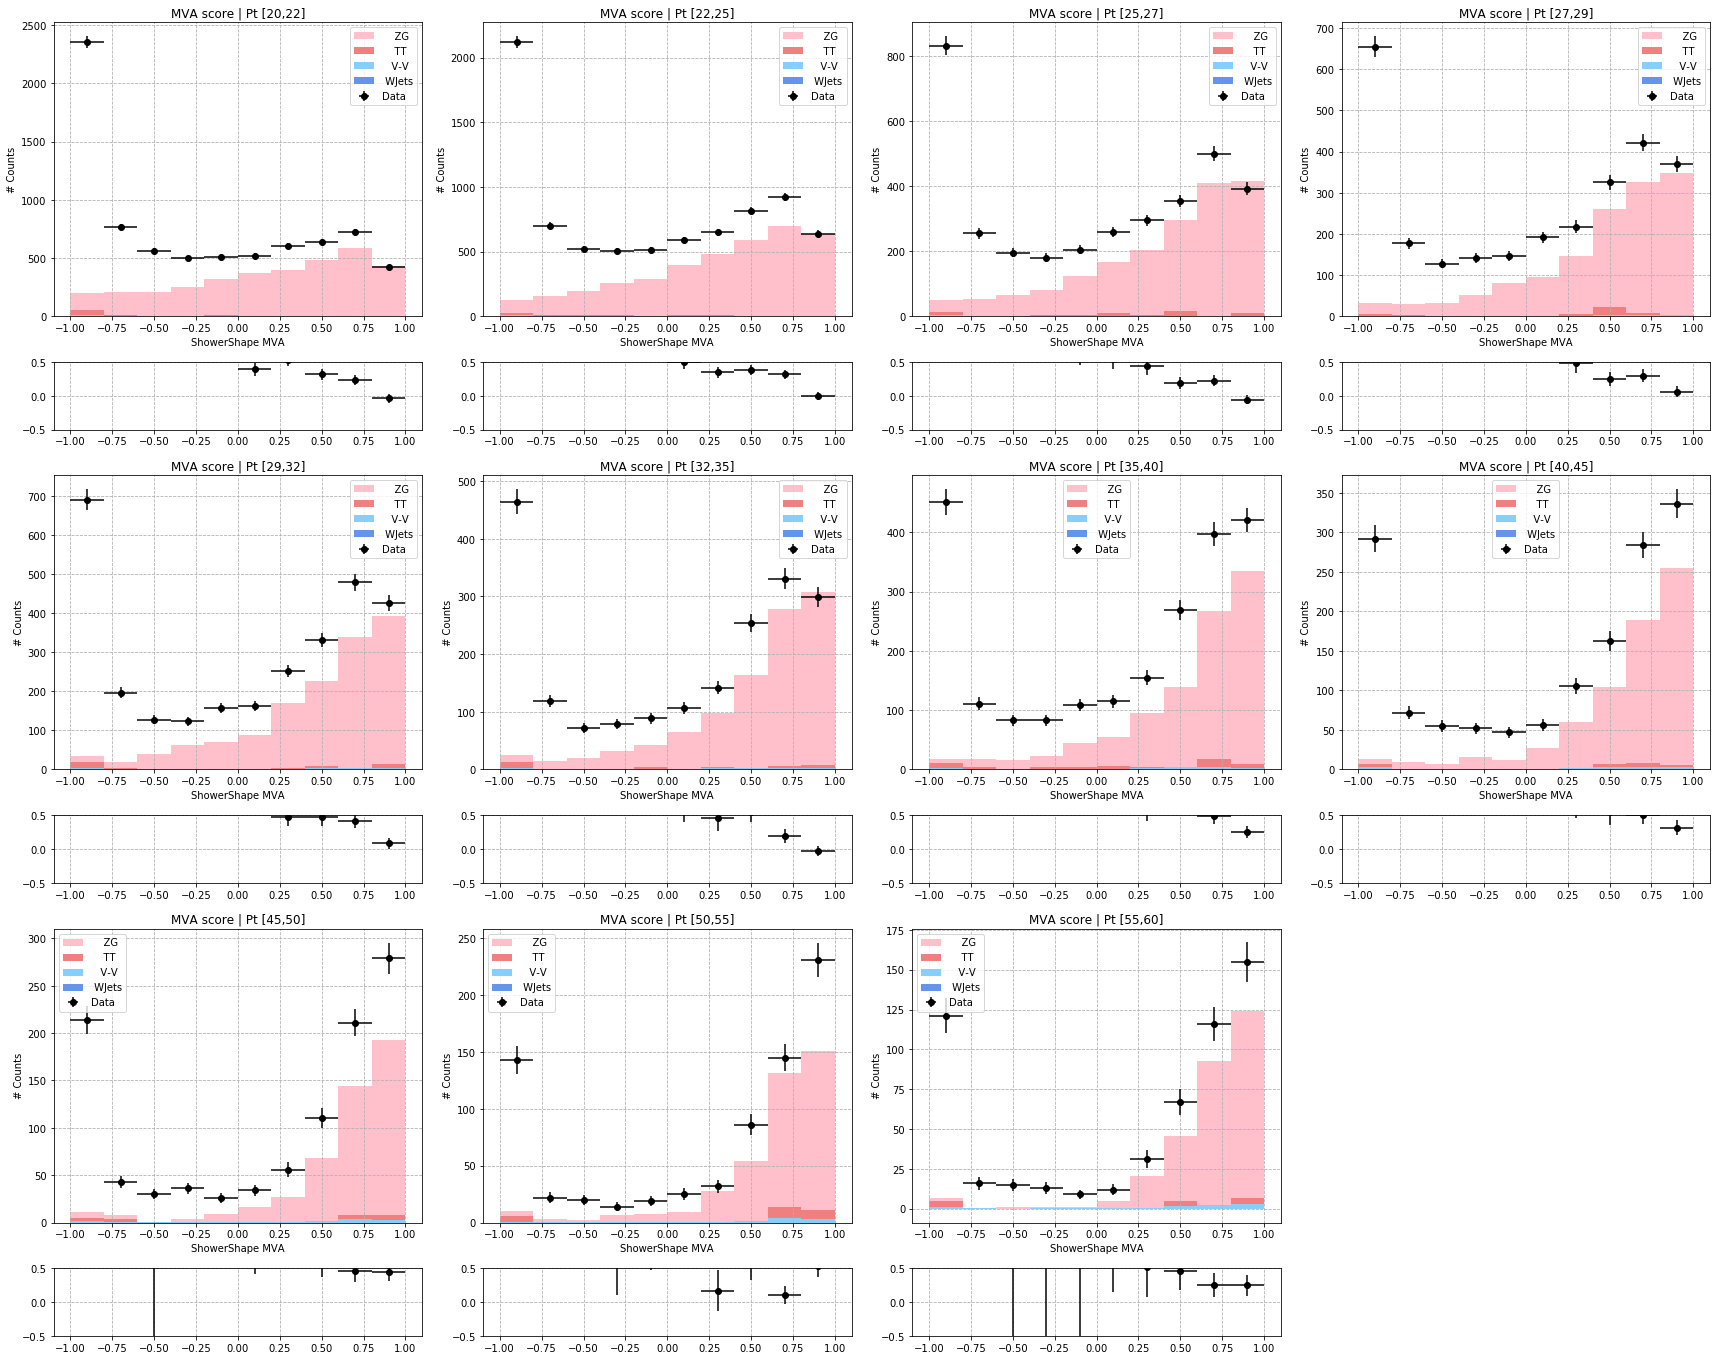

In [64]:
#ranges,bins = [-1,1],40
ranges,bins = [-1,1],10
ylim = [-0.5,0.5]
figx, figy = 24,19
nx , ny    = 3,4

log = False
if log:
    Log = [True,False]
else:
    Log = [False]
#ptBins = [20, 25, 30, 35, 45, 55]

for log in Log:
    row, col   = 0,0

        
    pathFile = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Corrections/"
    if log:
        fileName = "ShowerShapeMVA_log"
    else:
        fileName = "ShowerShapeMVA"
    fig = plt.figure(figsize=(figx,figy))
    for i in np.arange(len(ptBins)-1):
        if i != 0:
            if i%ny == 0:
                row += 1
                col = 0  
        
        ax = plt.subplot2grid((nx*4,ny),(row*4,col),rowspan = 3, colspan = 1)    
        mc = plt.hist(
                        [np.array(BDT[ph][d.name])[Ind[d.name][i]] for d in data[:-1]],
                        range    = ranges,
                        bins     = bins,
                        weights  = [d.GetWithCuts('weights')[Ind[d.name][i]] for d in data[:-1]],
                        histtype = 'stepfilled',
                        color    = colors[:-1],
                        stacked  = True,
                        label    = legend[:-1]
                        )
        plt.grid(linestyle='--')

        ax = plt.gca()
        y3,x3 =np.histogram(
                            np.array(BDT[ph][data[-1].name])[Ind[data[-1].name][i]],
                            range    = ranges,
                            bins     = bins,
                           )
        x3b = (x3[1:len(x3)] + x3[0:-1])/2
        dta =  ax.errorbar(x3b,
                            y3,
                            xerr      = np.diff(x3)/2,
                            yerr      = np.sqrt(y3),
                            color     ='k',
                            marker    ='o',
                            linestyle ='',
                            label     = legend[-1]
                           )
        if log:
            ax.set_yscale('log')
        plt.grid(linestyle='--')

        plt.title('MVA score | Pt [' + str(ptBins[i])+','+str(ptBins[i+1])+']')
        plt.ylabel('# Counts')
        plt.xlabel('ShowerShape MVA')
        plt.legend()
        lim = ax.get_xlim()
        
        ax = plt.subplot2grid((nx*4,ny),(row*4+3,col),rowspan = 1, colspan = 1)    
        
        ymc = mc[0][-1]
        ydata = dta[0]
        
        
        plt.errorbar(
                        x3b,
                        y3/ymc - 1,
                        xerr      = np.diff(x3)/2,
                        yerr      = y3/ymc*np.sqrt(1/y3+1/ymc),
                        color     = 'k',
                        marker    = 'o',
                        linestyle = '',
                        linewidth = 1.5
                        )
        ax.grid(linestyle = '--')
        ax.set_xlim(lim)
        ax.set_ylim(ylim)
        col += 1
        
        plt.tight_layout()
    fig.savefig(figpath+'ShowerShapeMVA/'+fileName+'_'+era+'_'+ph+'_PT'+str(ptBins[0])+'_'+str(ptBins[-1])+'_ETA'+str(etaBins[0])+'_'+str(round(etaBins[-1],2))+'.png')
    plt.show()


''

In [85]:

for ph in phVals:
    for d,i in zip(data,np.arange(len(data))):    
        df = pd.DataFrame({'MVA':BDT[ph][d.name] })
        df.to_csv(pathMVA+'/MVA_score/MVA_'+ph+'_'+data[i].name+'.csv')
'''
folderMVA = 'MVA_scores'
    
for ph in phVals:
    df = pd.DataFrame({d.name:BDT[ph][d.name] for d in data})
    df.to_csv(pathMVA+'/MVA_'+ph+'.csv')
'''

"\nfolderMVA = 'MVA_scores'\n    \nfor ph in phVals:\n    df = pd.DataFrame({d.name:BDT[ph][d.name] for d in data})\n    df.to_csv(pathMVA+'/MVA_'+ph+'.csv')\n"

In [47]:
print(len(data[1].GetWithCuts('photonOneMVA')),
      len(BDT[data[1].name])
     )

116983 116983


In [ ]:
#ranges,bins = [-1,1],40
#ranges,bins = [-1,1],10
ranges,bins = [-1.5,1.5],10
ylim = [-0.5,0.5]
figx, figy = 24,19
nx , ny    = 3,4
#ptBins = [20, 25, 30, 35, 45, 55]

for log in [True,False]:
    row, col   = 0,0

        
    pathFile = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Corrections/"
    if log:
        fileName = "ShowerShapeMVA_log"
    else:
        fileName = "ShowerShapeMVA"
    fig = plt.figure(figsize=(figx,figy))
    if i != 0:
        if i%ny == 0:
            row += 1
            col = 0  

    ax = plt.subplot2grid((nx*4,ny),(row*4,col),rowspan = 3, colspan = 1)    
    mc = plt.hist(
                    [np.array(BDT[d.name]) for d in data[:-1]],
                    range    = ranges,
                    bins     = bins,
                    weights  = [d.GetWithCuts('weights') for d in data[:-1]],
                    histtype = 'stepfilled',
                    color    = colors[:-1],
                    stacked  = True,
                    label    = legend[:-1]
                    )
    plt.grid(linestyle='--')

    ax = plt.gca()
    y3,x3 =np.histogram(
                        np.array(BDT[data[-1].name]),
                        range    = ranges,
                        bins     = bins,
                       )
    x3b = (x3[1:len(x3)] + x3[0:-1])/2
    ax.errorbar(x3b,
                y3,
                xerr      = np.diff(x3)/2,
                yerr = np.sqrt(y3),
                color     ='k',
                marker    ='o',
                linestyle ='',
                label     = legend[-1]
               )
    if log:
        ax.set_yscale('log')
    plt.grid(linestyle='--')

    #plt.title('MVA score | Pt [' + str(ptBins[i])+','+str(ptBins[i+1])+']')
    plt.ylabel('# Counts')
    plt.xlabel('ShowerShape MVA')
    plt.legend()
    lim = ax.get_xlim()

    ax = plt.subplot2grid((nx*4,ny),(row*4+3,col),rowspan = 1, colspan = 1)    

    ymc = mc[0][-1]


    plt.errorbar(
                    x3b,
                    y3/ymc - 1,
                    xerr      = np.diff(x3)/2,
                    yerr      = y3/ymc*np.sqrt(1/y3+1/ymc),
                    color     = 'k',
                    marker    = 'o',
                    linestyle = '',
                    linewidth = 1.5
                    )
    ax.grid(linestyle = '--')
    ax.set_xlim(lim)
    ax.set_ylim(ylim)
    col += 1

    plt.tight_layout()
#fig.savefig(figpath+'ShowerShapeMVA/'+fileName+'.png')
plt.show()


# ----------------- IOIOIOOIOIOO--------------

In [25]:
ptBins = [20, 25, 30, 35, 45, 55, 65, 75, 85, 95, 120, 1000]
#ptBins = [20, 25, 30, 35, 45, 55]
var = 'photonOnePt'
Ind = {}

for d in data:
    Ind[d.name] = []
    for i in np.arange(len(ptBins[:-1])):
        ptInd = np.logical_and(
                            np.array(d.GetWithCuts(var)) >= ptBins[i], 
                            np.array(d.GetWithCuts(var)) <  ptBins[i+1]
                          )
        #etaInd = np.logical_and(
        #                        np.array(sample['photonOneEta']) >= etaBins[i], 
        #                        np.array(sample['photonOneEta']) <  etaBins[i+1]
        #      v                )

        #Ind = np.logical_and(ptInd,etaInd)
        Ind[d.name].append(ptInd)
        
        



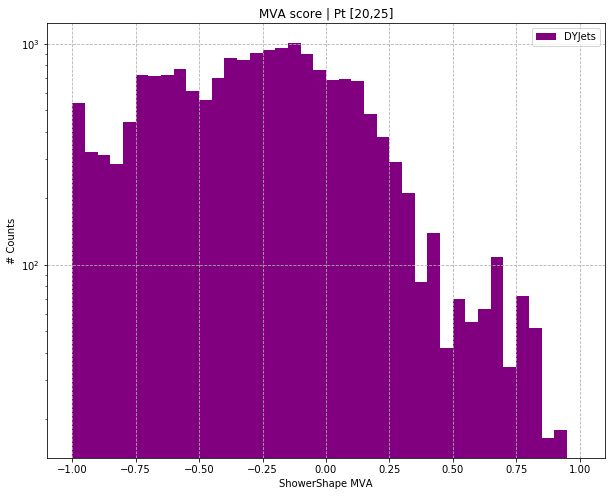

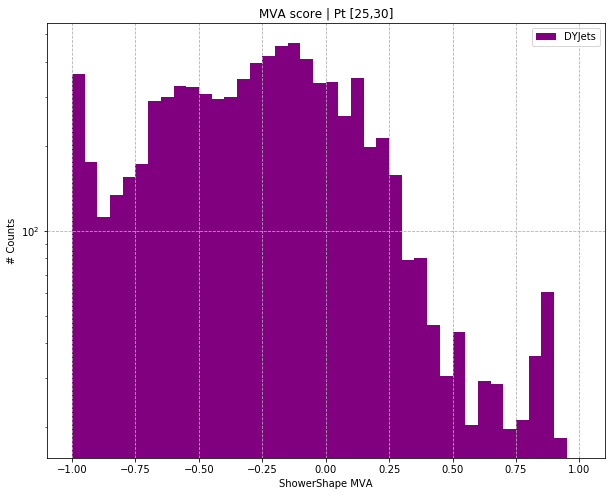

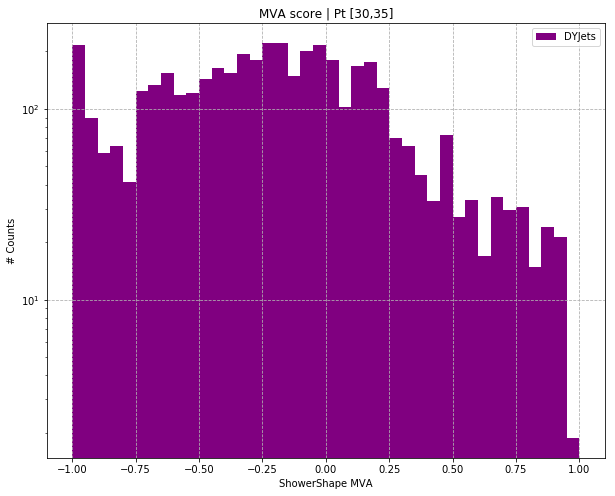

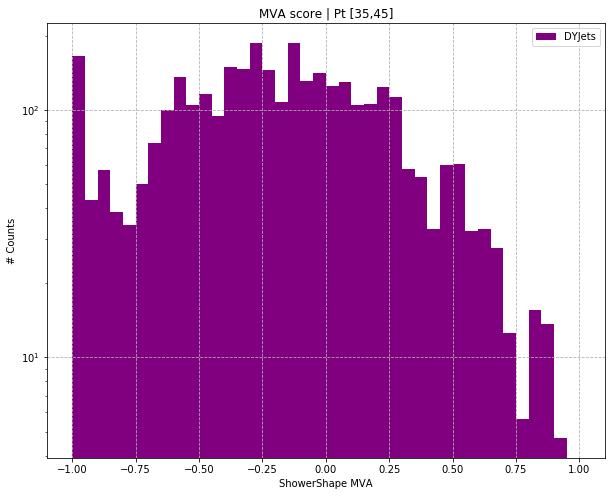

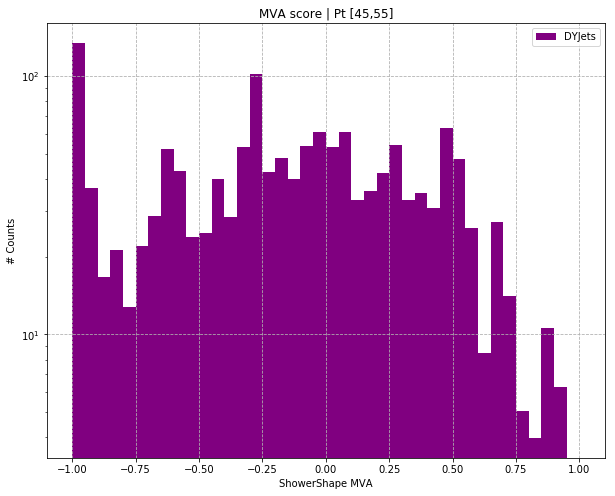

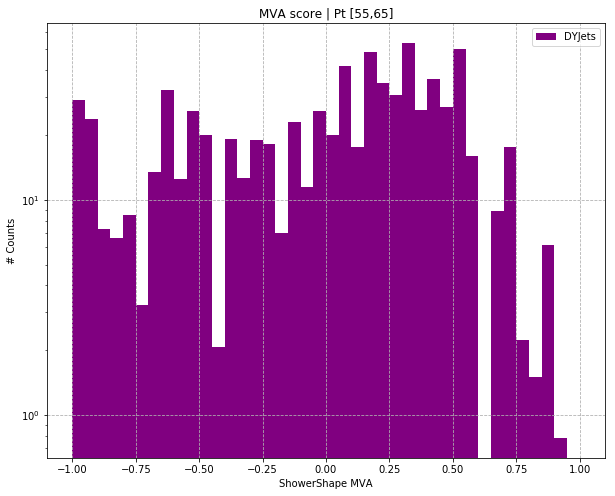

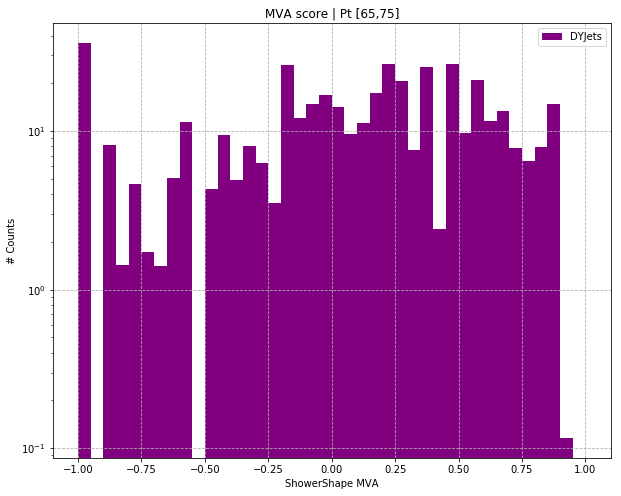

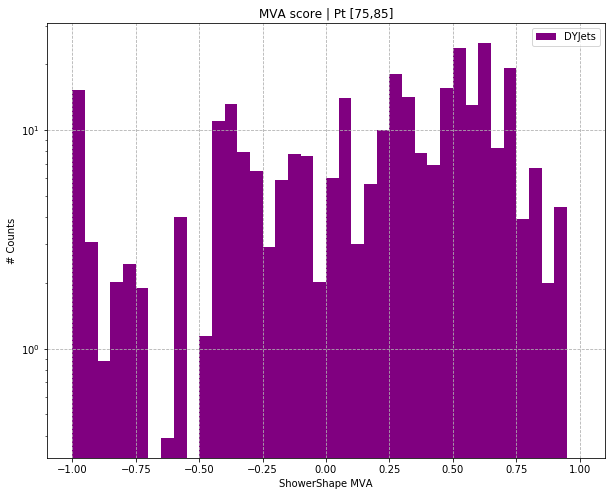

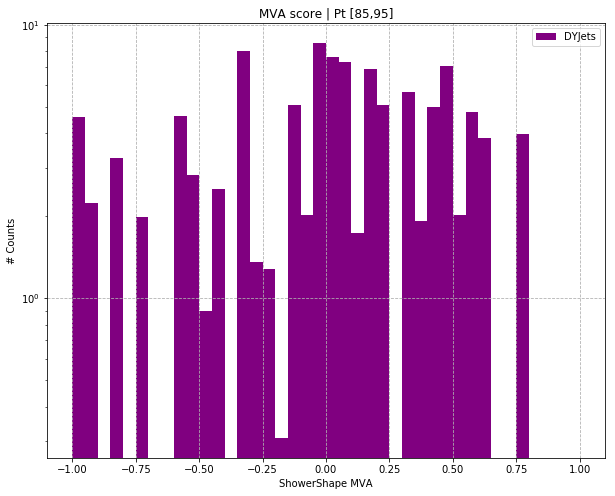

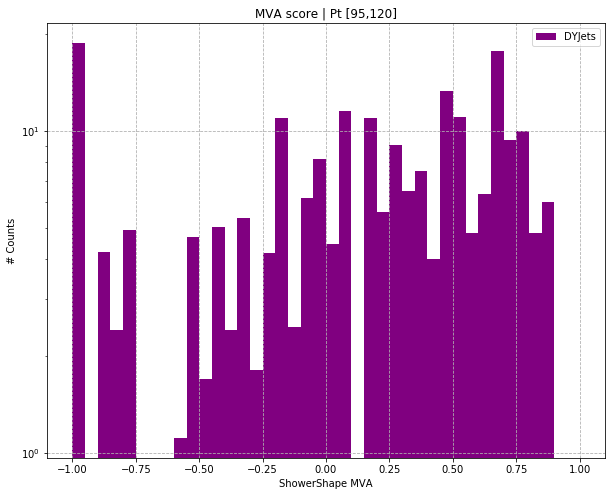

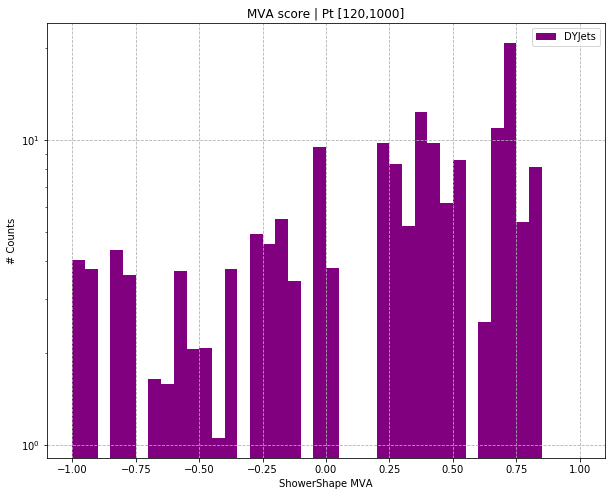

In [26]:
ranges,bins = [-1,1],40
#figx, figy = 24,19
figx, figy = 10,8
log        = True
dataSample = 'DYJets'
color      = 'purple'

#fig = plt.figure(figsize=(figx,figy))
pathFile = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Corrections/"
if log:
    fileName = "ShowerShapeMVA_log.png"
else:
    fileName = "ShowerShapeMVA.png"

for d in data:
    if d.name == dataSample:
        for i in np.arange(len(ptBins)-1):
            #plt.subplot(3,4,i+1)
            fig = plt.figure(figsize=(figx,figy))
            plt.hist(
                    #[np.array(BDT[d.name])[Ind[d.name][i]] for d in data[:-1]],
                    np.array(BDT[d.name])[Ind[d.name][i]] ,
                    range    = ranges,
                    bins     = bins,
                    #weights  = [d.GetWithCuts('weights')[Ind[d.name][i]] for d in data[:-1]],
                    weights  = d.GetWithCuts('weights')[Ind[d.name][i]],
                    histtype = 'stepfilled',
                    #color    = colors[:-1],
                    color    = color,
                    stacked  = True,
                    label    = dataSample
                    )
            plt.grid(linestyle='--')

            ax = plt.gca()

            if log:
                ax.set_yscale('log')
            plt.grid(linestyle='--')

            plt.title('MVA score | Pt [' + str(ptBins[i])+','+str(ptBins[i+1])+']')
            plt.ylabel('# Counts')
            plt.xlabel('ShowerShape MVA')
            plt.legend()

            fig.savefig(figpath+'ShowerShapeMVA/'+dataSample+'_'+fileName+'_'+str(ptBins[i])+'_'+str(ptBins[i+1])+'.png')
            plt.show()


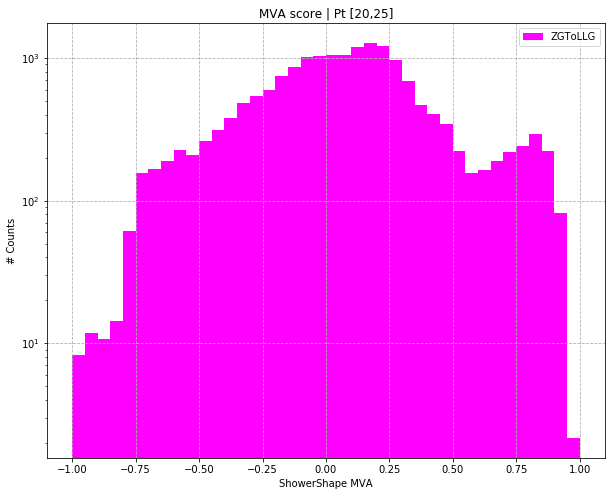

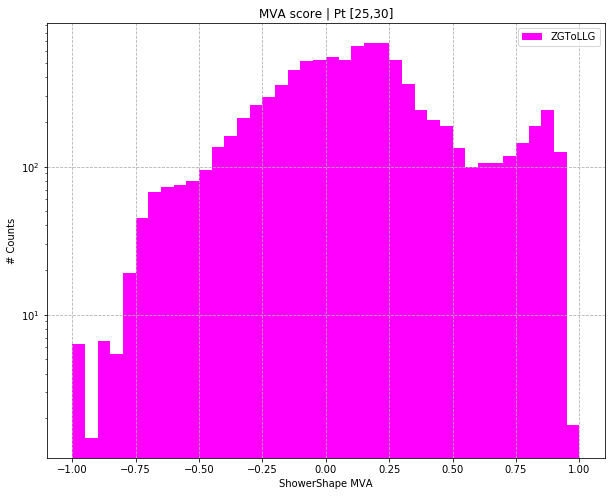

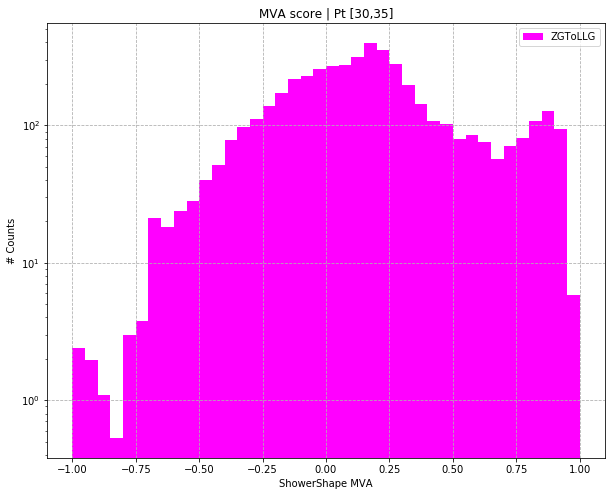

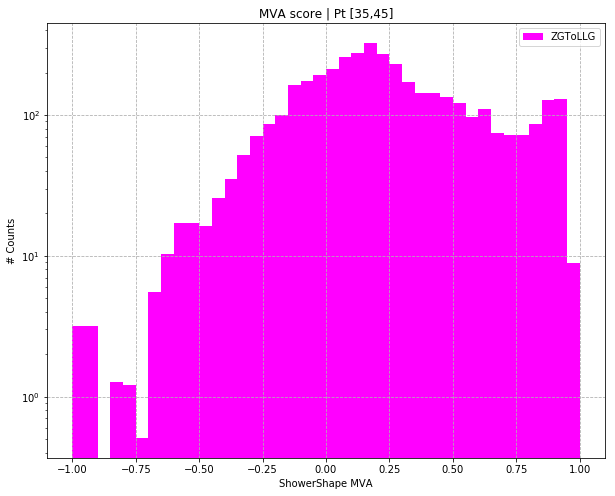

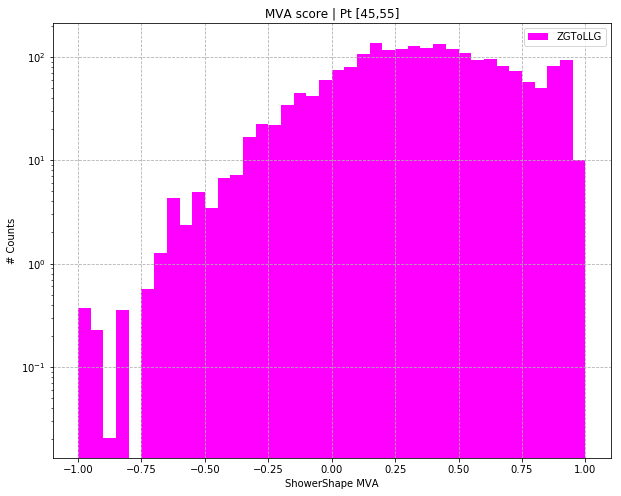

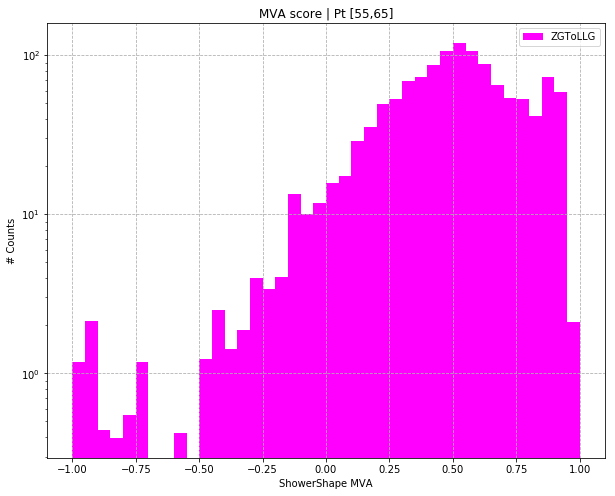

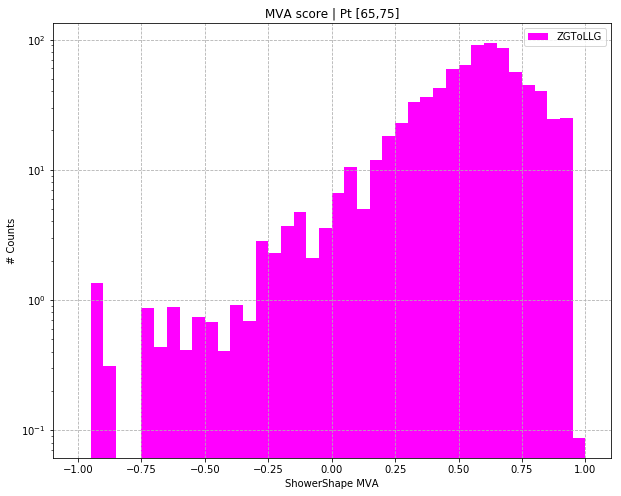

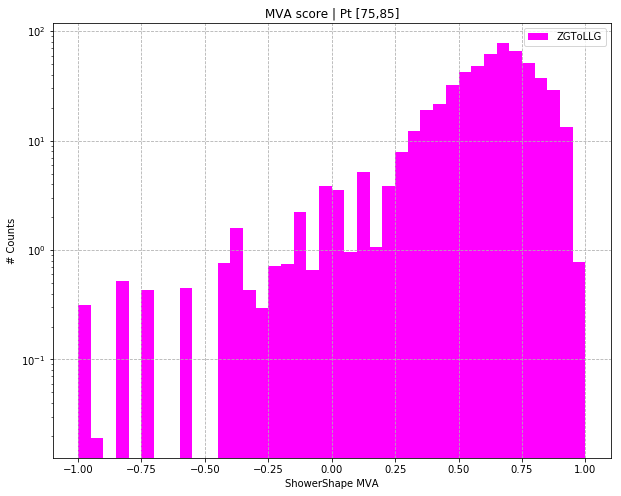

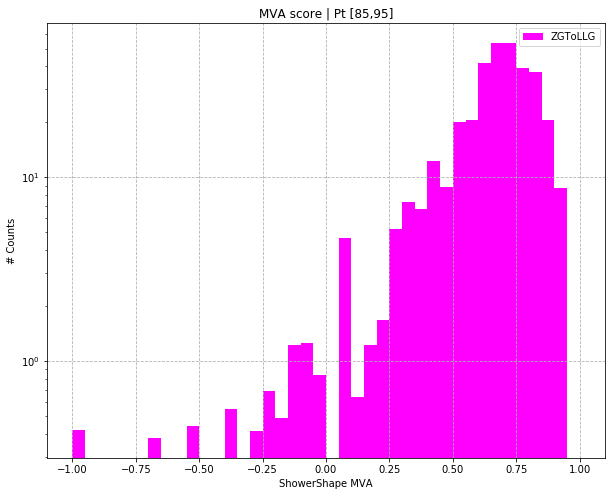

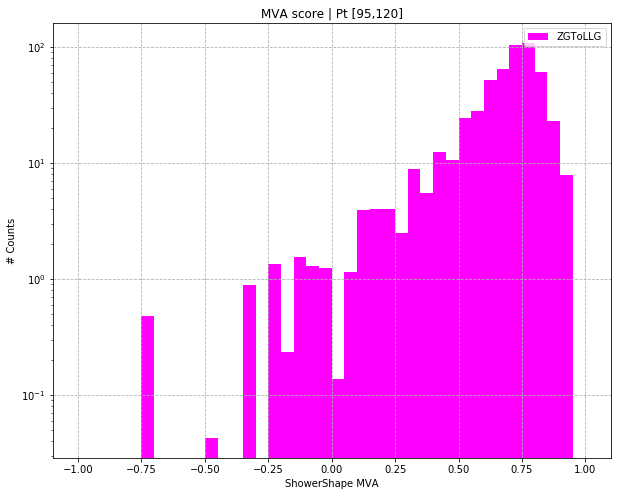

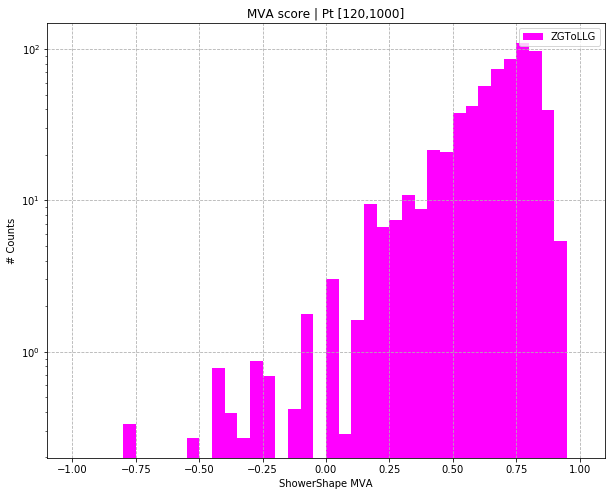

In [30]:
ranges,bins = [-1,1],40
#figx, figy = 24,19
figx, figy = 10,8
log        = True
dataSample = 'ZGToLLG'
color      = 'magenta'

#fig = plt.figure(figsize=(figx,figy))
pathFile = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Corrections/"
if log:
    fileName = "ShowerShapeMVA_log.png"
else:
    fileName = "ShowerShapeMVA.png"

for d in data:
    if d.name == dataSample:
        for i in np.arange(len(ptBins)-1):
            #plt.subplot(3,4,i+1)
            fig = plt.figure(figsize=(figx,figy))
            plt.hist(
                    #[np.array(BDT[d.name])[Ind[d.name][i]] for d in data[:-1]],
                    np.array(BDT[d.name])[Ind[d.name][i]] ,
                    range    = ranges,
                    bins     = bins,
                    #weights  = [d.GetWithCuts('weights')[Ind[d.name][i]] for d in data[:-1]],
                    weights  = d.GetWithCuts('weights')[Ind[d.name][i]],
                    histtype = 'stepfilled',
                    #color    = colors[:-1],
                    color    = color,
                    stacked  = True,
                    label    = dataSample
                    )
            plt.grid(linestyle='--')

            ax = plt.gca()

            if log:
                ax.set_yscale('log')
            plt.grid(linestyle='--')

            plt.title('MVA score | Pt [' + str(ptBins[i])+','+str(ptBins[i+1])+']')
            plt.ylabel('# Counts')
            plt.xlabel('ShowerShape MVA')
            plt.legend()

            fig.savefig(figpath+'ShowerShapeMVA/'+dataSample+'_'+fileName+'_'+str(ptBins[i])+'_'+str(ptBins[i+1])+'.png')
            plt.show()


In [ ]:
#alpha, beta, rho = 0.5,0.5,1
#del alpha, beta,rho
k,N = 10,100

In [ ]:
eqs((1,1,1))

In [ ]:
'''
def equations(p):
    x, y = p
    return (x+y**2-4, np.exp(x) + x*y - 3)
x, y =  fsolve(equations, (1, 1))
#print equations((x, y))
'''

def EQS(k,N,arg):
    alpha,beta,rho = arg
    lamb = 0.68
    
    G  = lambda       k,N: gamma(k+1)*gamma(N-k+1)/gamma(N+2)
    Bx = lambda     x,k,N: 1/G(k,N)*betainc(k+1,N-k+1,alpha)
    T2 = lambda rho,x,k,N: rho*(x**k)*(1-x)**(N-k)
    
    #print(  G(k,N), T2( beta,rho,k,N),Bx(alpha, k,N))
    
    return (
            G(k,N) + T2( beta,rho,k,N),
            G(k,N) + T2(alpha,rho,k,N),
            Bx(alpha, k,N) - Bx(beta,k,N) - lamb*G(k,N)
            )

#print("EQS: ",EQS(k,N,(alpha,beta,rho)))
print("EQS: ",EQS(10,20,(0.5, 0.5,1)))

eqs = lambda arg: EQS(10,20,arg)
alpha,beta,rho =  fsolve(eqs, (0.6, 0,1))

print(alpha,beta,rho)


In [ ]:
print(
    G(k,N),
    T2( beta,rho,k,N),
    Bx(alpha, k,N)
    )


In [ ]:
#print("EQS: ",EQS(100,200,(0.1, 0.1,0.1)))
print("EQS: ",EQS(10,20,(0.5, 0.5,1)))

In [ ]:
G  = lambda       k,N: gamma(k+1)*gamma(N-k+1)/gamma(N+2)
Bx = lambda     x,k,N: 1/G(k,N)*betainc(k+1,N-k+1,alpha)
T2 = lambda rho,x,k,N: rho*(x**k)*(1-x)**(N-k)

In [ ]:
print(
G(10,20) + T2( 8,1,10,20),
G(10,20) + T2( 9,1,10,20),
Bx(8, 10,20) - Bx(8,10,20) 
)